<a href="https://colab.research.google.com/github/InbalBolshinsky/DL_finalProject/blob/main/Lung_Cancer_Project_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50

In [82]:
!pip install kagglehub
import kagglehub

# Download dataset (default behavior)
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Dataset downloaded to:", path)



Dataset downloaded to: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [83]:
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset from default location to Google Drive
!cp -r /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset /content/drive/MyDrive/KaggleDatasets/LungCancer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create directory '/content/drive/MyDrive/KaggleDatasets/LungCancer': No such file or directory


In [84]:
import os

base_path = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
print("Base path:", base_path)

if os.path.exists(base_path):
    for root, dirs, files in os.walk(base_path):
        print(f"Directory: {root}")
        for d in dirs:
            print(f"  Subdirectory: {d}")
        #for f in files:
           # print(f"  File: {f}")
else:
    print(f"Path does not exist: {base_path}")



Base path: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
  Subdirectory: Test cases
  Subdirectory: The IQ-OTHNCCD lung cancer dataset
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/Test cases
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset
  Subdirectory: The IQ-OTHNCCD lung cancer dataset
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
  Subdirectory: Bengin cases
  Subdirectory: Normal cases
  Subdirectory: Malignant cases
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/B

In [85]:
input_shape = (128, 128, 3)
num_classes = 3  # Normal, Benign, Malignant

# Load and preprocess images
images = []
labels = []
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [86]:
size_data = {}
for i in categories:
    # Fixed: Corrected the path to point to the image directory
    directory = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
    directory = os.path.join(directory, i) # Construct path to images in a category
    class_num = categories.index(i)
    temp_dict = {}
    # Fixed: Changed from path to directory, and added a loop
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file) # Construct filepath for each image
            # Check if file is an image to avoid errors
            if filepath.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    height, width, channels = imageio.imread(filepath).shape
                    if str(height) + ' x ' + str(width) in temp_dict:
                        temp_dict[str(height) + ' x ' + str(width)] += 1
                    else:
                        temp_dict[str(height) + ' x ' + str(width)] = 1
                except ValueError:
                    print(f"Skipping {filepath}: not a valid image file.")

    size_data[i] = temp_dict

size_data

<ipython-input-86-546d55099baf>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases
Bengin cases


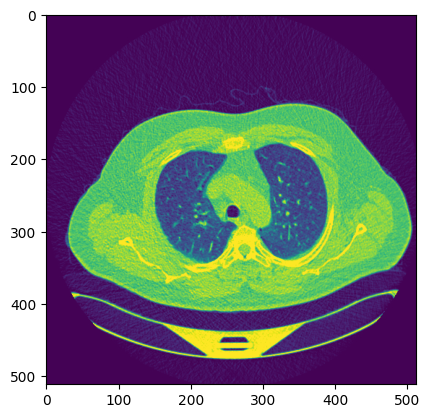

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases
Malignant cases


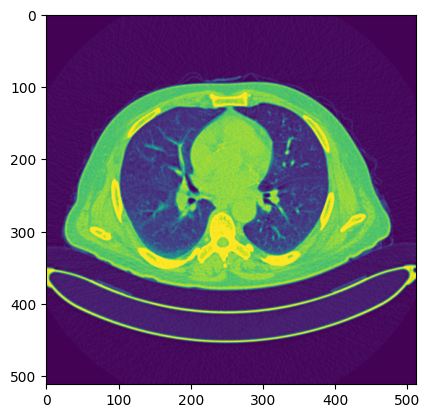

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases
Normal cases


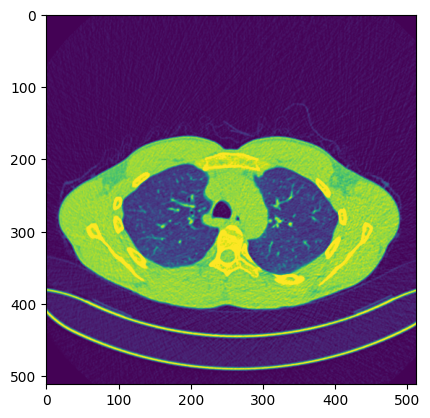

In [87]:
directory = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
for i in categories:
    category_path = os.path.join(directory, i) # Construct path for each category
    print(category_path)
    class_num = categories.index(i)
    for file in os.listdir(category_path): # List files in the category path
        filepath = os.path.join(category_path, file) # Construct filepath using category path
        print(i)
        img = cv2.imread(filepath, 0)
        if img is not None: # Check if image was loaded successfully
            plt.imshow(img)
            plt.show()
            break
        else:
            print(f"Failed to load image: {filepath}")

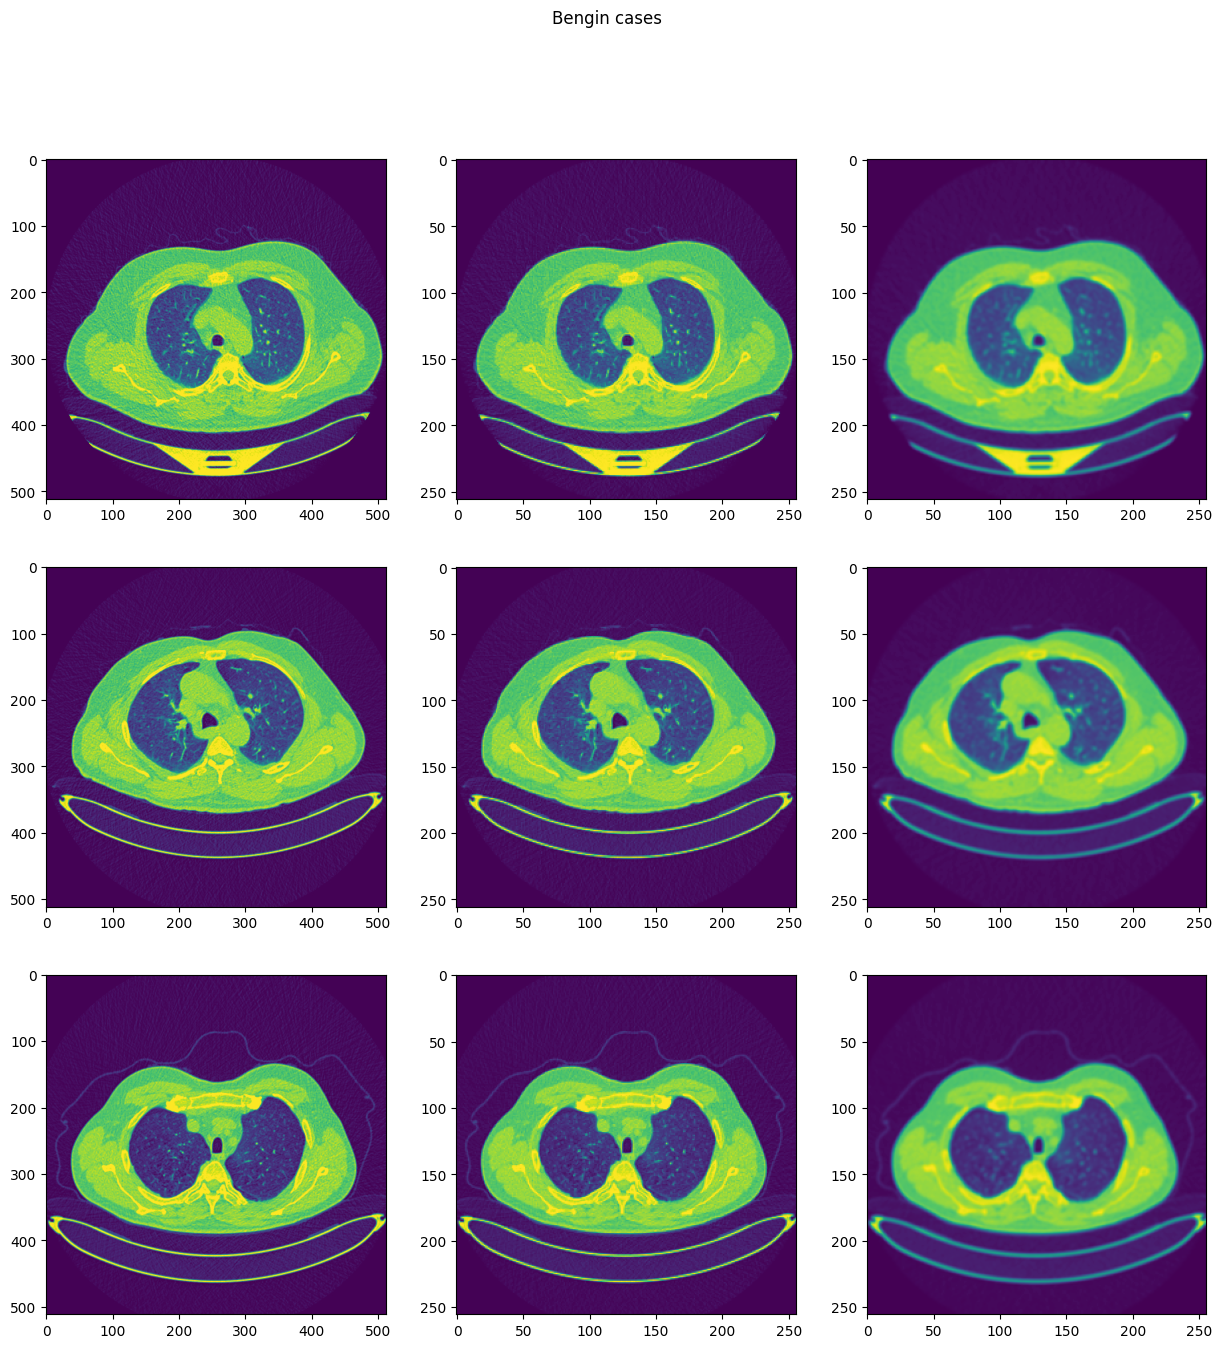

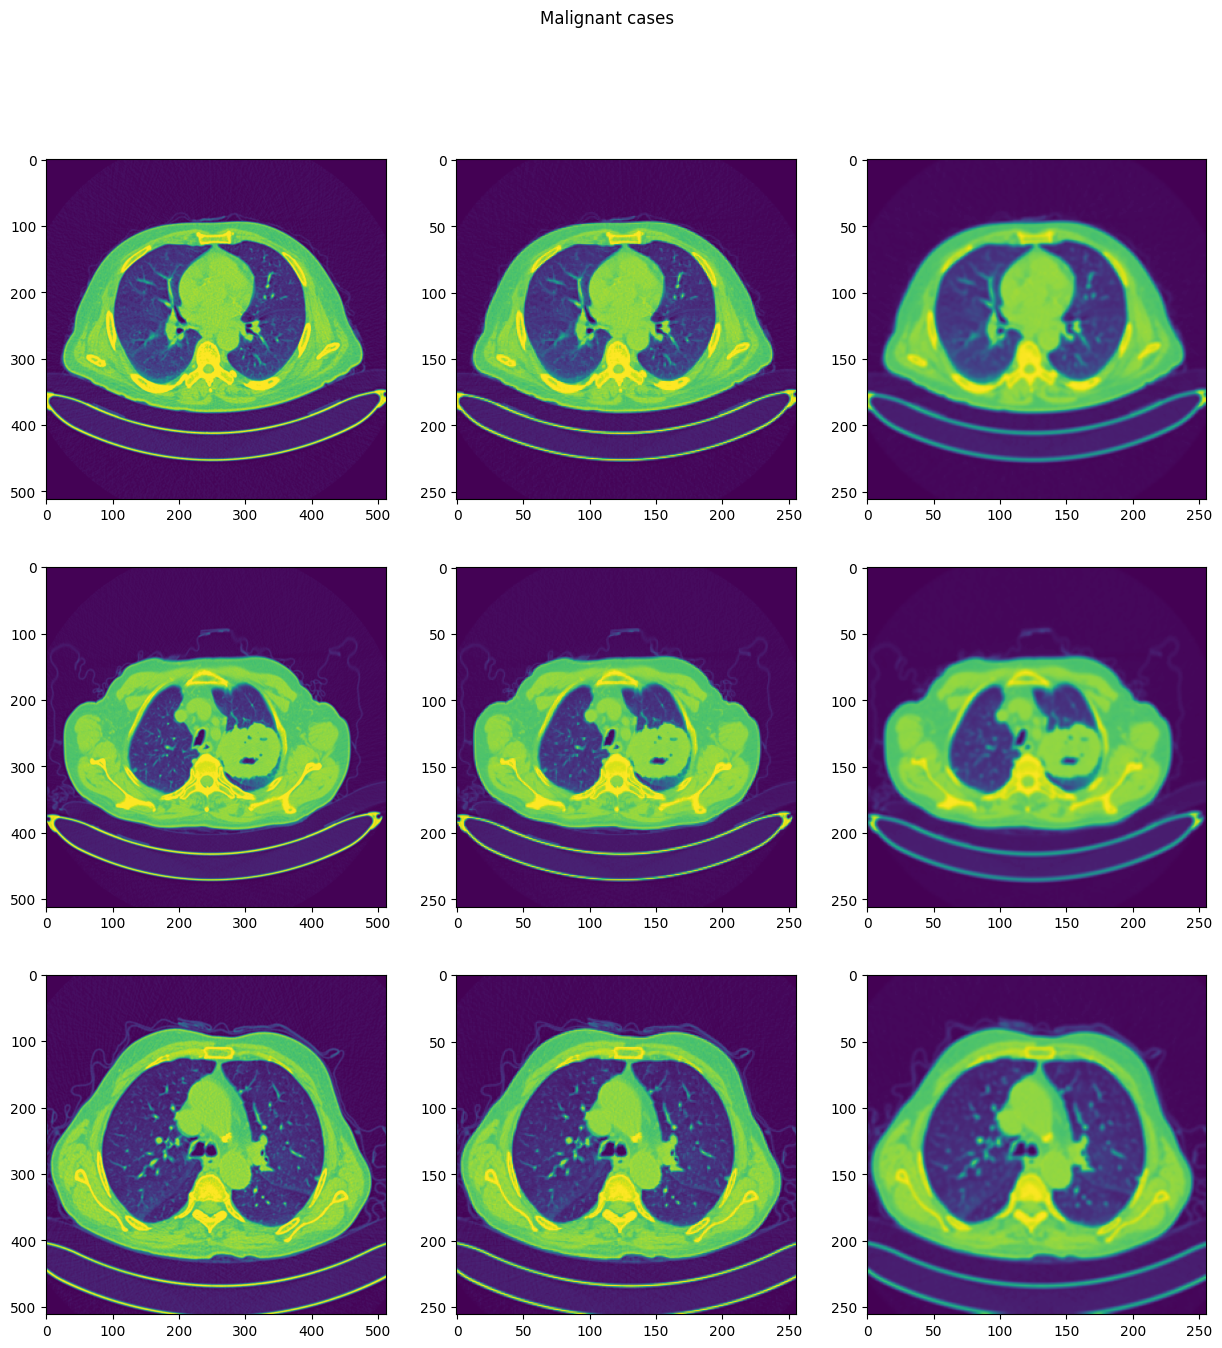

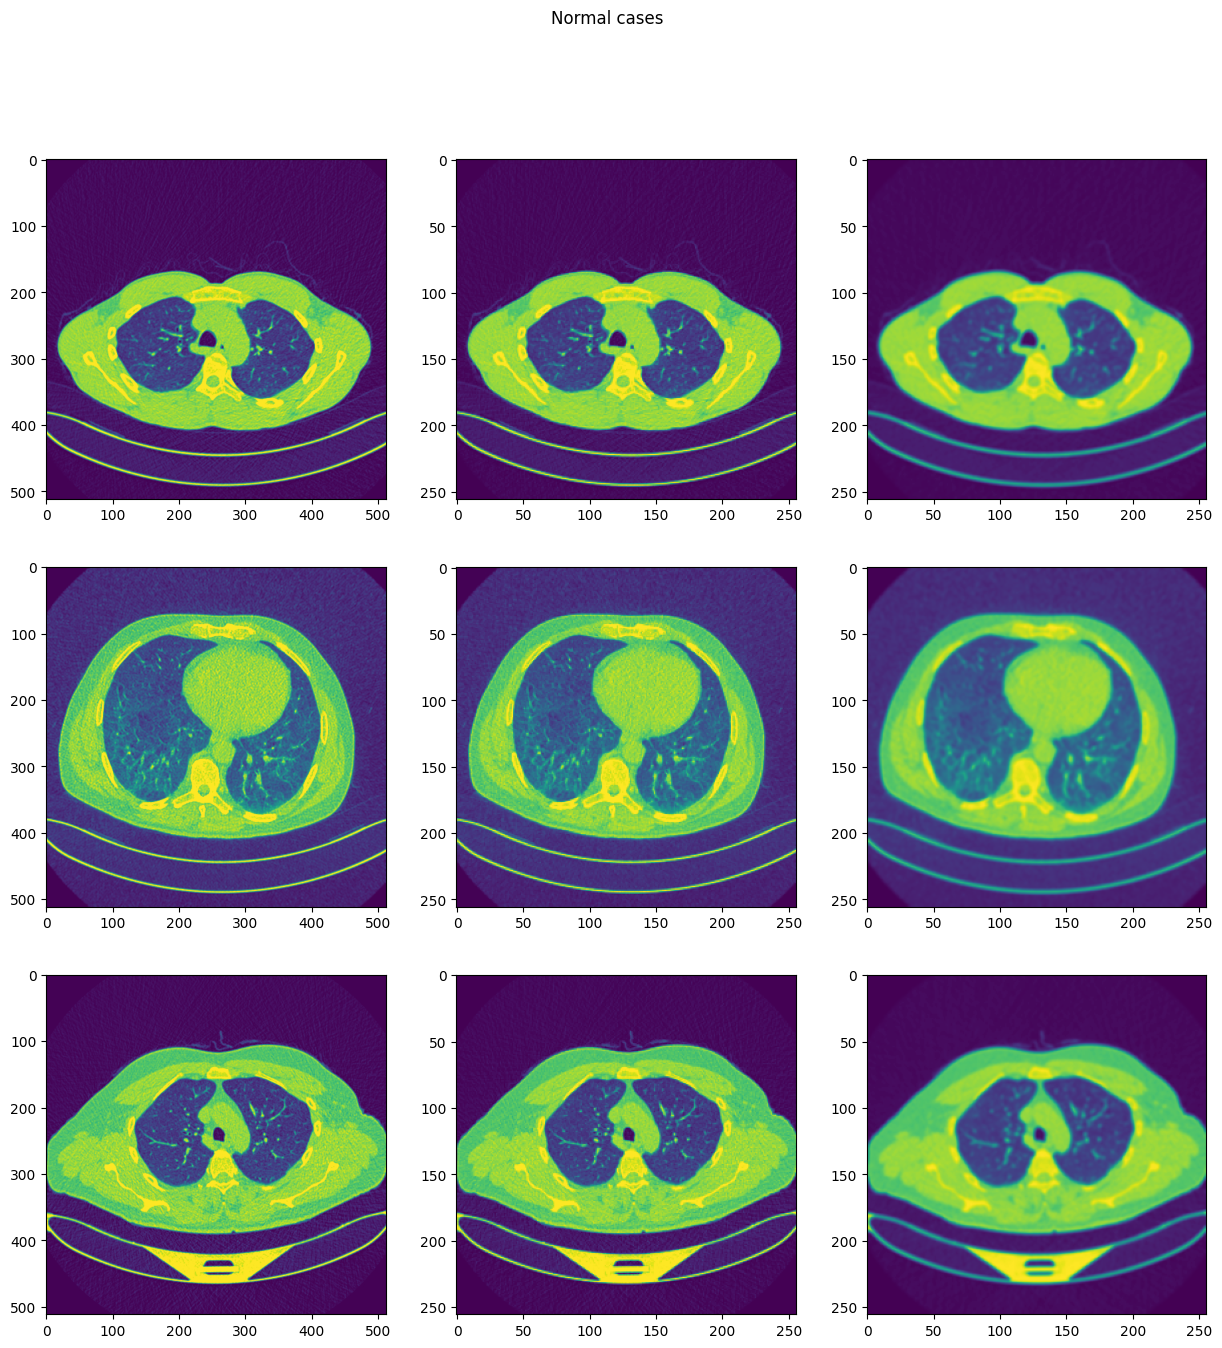

In [88]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

In [89]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [90]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


Applying SMOTE to oversample the data

In [91]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [92]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [93]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [94]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


#Building first model

In [95]:
model1 = Sequential()

# Convolutional layers
model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model1.add(Flatten())

# Fully connected layers
model1.add(Dense(512, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │     117,965,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,336,515 (451.42 MB)

 Trainable params: 118,336,515 (451.42 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.5986 - loss: 0.8911 - val_accuracy: 0.9309 - val_loss: 0.2110
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.9716 - loss: 0.1065 - val_accuracy: 0.9745 - val_loss: 0.0781
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9876 - loss: 0.0372 - val_accuracy: 0.9891 - val_loss: 0.0727
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9923 - loss: 0.0266 - val_accuracy: 0.9745 - val_loss: 0.0427
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9951 - loss: 0.0158 - val_accuracy: 0.9855 - val_loss: 0.0404
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9985 - loss: 0.0085 - val_accuracy: 0.9818 - val_loss: 0.0736
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9976 - loss: 0.0115 - val_accuracy: 0.9782 - val_loss: 0.0574
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9995 - loss: 0.0016 - 

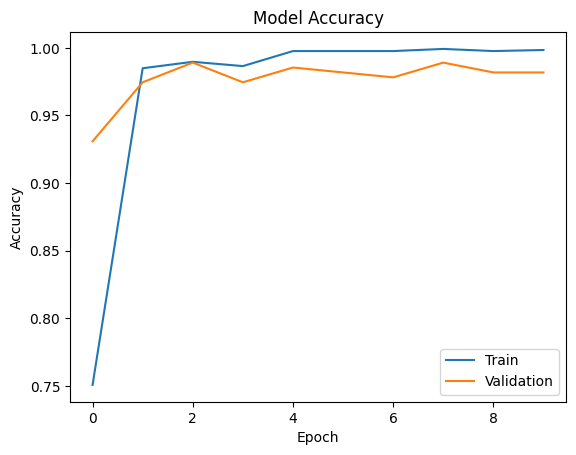

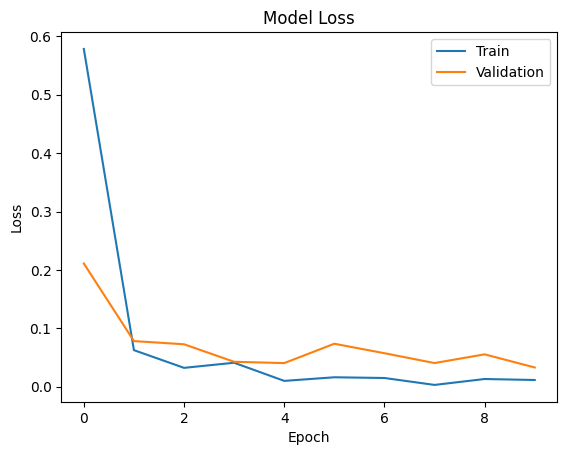

In [100]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.99      1.00      1.00       141
           2       0.99      0.96      0.98       104

    accuracy                           0.98       275
   macro avg       0.96      0.98      0.97       275
weighted avg       0.98      0.98      0.98       275



Confusion Matrix:
 [[ 29   0   1]
 [  0 141   0]
 [  3   1 100]]


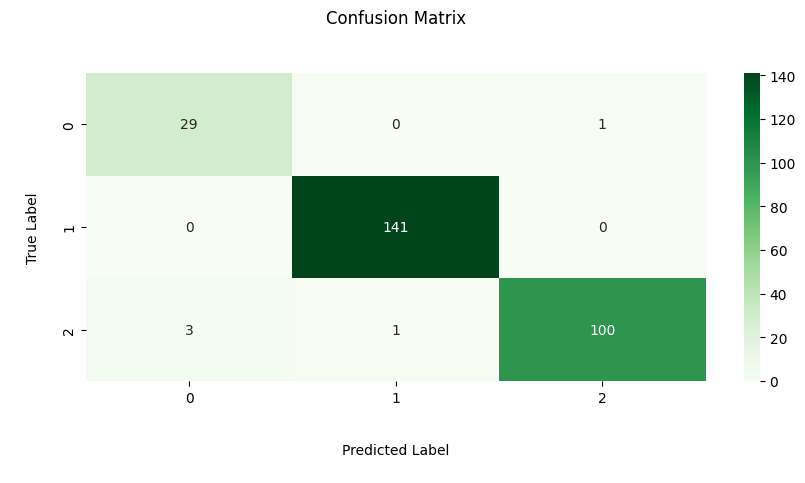

In [101]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

In [112]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
    patience=3,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model1.compile(
    optimizer=optimizer,
   loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model1.fit(
    X_train_sampled,
    y_train_sampled,
    batch_size=8,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop]  # Add the EarlyStopping callback here
)


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9325 - loss: 0.1674 - val_accuracy: 0.9818 - val_loss: 0.0766
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9967 - loss: 0.0237 - val_accuracy: 0.9818 - val_loss: 0.0568
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9996 - loss: 0.0052 - val_accuracy: 0.9855 - val_loss: 0.0914
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9948 - loss: 0.0245 - val_accuracy: 0.9891 - val_loss: 0.1243
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9968 - loss: 0.0126 - val_accuracy: 0.9891 - val_loss: 0.1049


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.99      0.99      0.99       141
           2       0.96      0.99      0.98       104

    accuracy                           0.98       275
   macro avg       0.99      0.97      0.98       275
weighted avg       0.98      0.98      0.98       275



Confusion Matrix:
 [[ 28   0   2]
 [  0 139   2]
 [  0   1 103]]


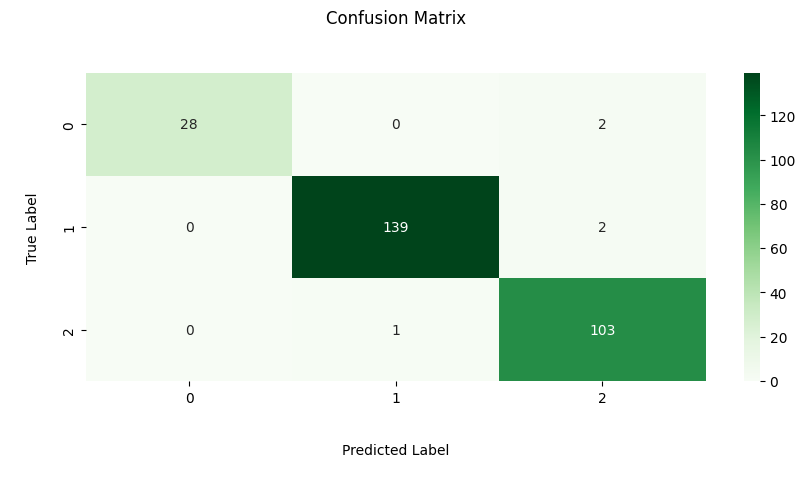

In [113]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

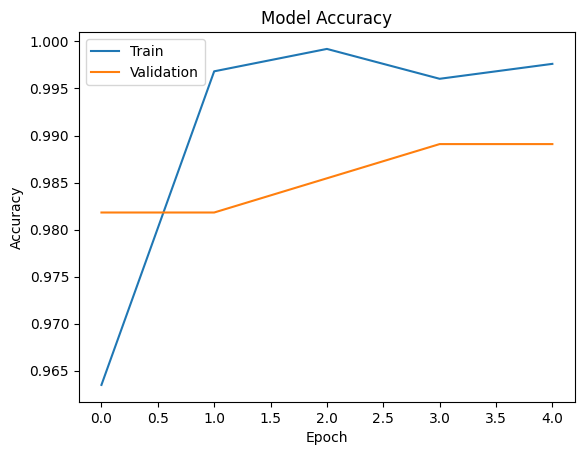

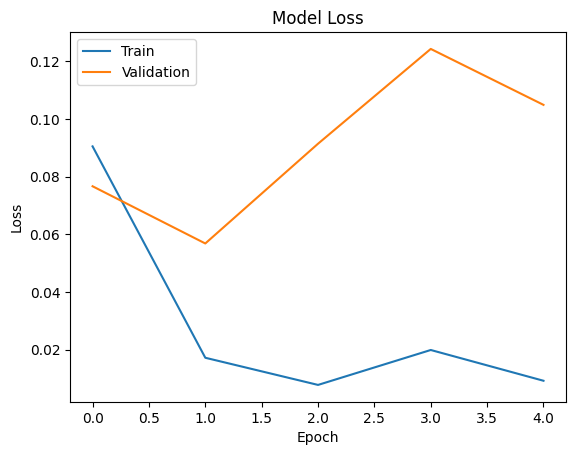

In [114]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


#Tunning Hyperparameters

In [37]:
# TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Keras Tuner for hyperparameter tuning
!pip install keras-tuner
import keras_tuner as kt

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [78]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Conv2D(
        filters=hp.Choice('conv_1_filters', values=[16, 32]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(256, 256, 1)  # Define input shape
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces spatial dimensions by half

    # Second convolutional layer
    model.add(Conv2D(
        filters=hp.Choice('conv_2_filters', values=[32, 64]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces dimensions further

    # Third convolutional layer
    model.add(Conv2D(
        filters=hp.Choice('conv_3_filters', values=[64, 128]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Final pooling to reduce dimensions

    # Flatten and fully connected layers
    model.add(Flatten())  # Now the flattened size will be smaller
    model.add(Dense(
        units=hp.Choice('dense_units', values=[64, 128]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model1.summary()

    return model


In [63]:
# EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=3,          # Stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True  # Revert to the best weights
)

In [64]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  # Reduce max epochs
    factor=2,      # Reduce the number of trials per round
    directory='hyperparameter_tuning',
    project_name='lung_cancer_model'
)


Reloading Tuner from hyperparameter_tuning/lung_cancer_model/tuner0.json


In [65]:
tuner.search(
    X_train, y_train,  # Training data
    epochs=5,                         # Number of epochs for each trial
    validation_data=(X_valid, y_valid), # Validation data
    callbacks=[early_stop],           # Early stopping callback
    batch_size=4
)

Trial 17 Complete [00h 00m 39s]
val_accuracy: 0.8818181753158569

Best val_accuracy So Far: 0.9909090995788574
Total elapsed time: 00h 17m 43s


In [66]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get the best hyperparameter set
print("Best Hyperparameters:", best_hps.values)

Best Hyperparameters: {'conv_1_filters': 32, 'conv_2_filters': 64, 'conv_3_filters': 128, 'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [67]:
# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(
    X_train, y_train,
    epochs=20,  # You can extend training here
    batch_size=16,  # You can set this to the best batch size if tuned
    validation_data=(X_valid, y_valid)
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.5554 - loss: 0.9218 - val_accuracy: 0.7227 - val_loss: 0.6417
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7354 - loss: 0.6495 - val_accuracy: 0.8591 - val_loss: 0.3895
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8519 - loss: 0.3708 - val_accuracy: 0.9136 - val_loss: 0.2987
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9484 - loss: 0.1866 - val_accuracy: 0.9636 - val_loss: 0.1624
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9814 - loss: 0.1011 - val_accuracy: 0.9727 - val_loss: 0.0966
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9874 - loss: 0.0678 - val_accuracy: 0.9500 - val_loss: 0.1399
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9899 - loss: 0.0537 - val_accuracy: 0.9773 - val_loss: 0.0594
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9940 - loss: 0.0304 - val_accuracy: 0.9818 -

In [69]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_valid, y_valid)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - accuracy: 0.9964 - loss: 0.0116
Test Loss: 0.02573546953499317
Test Accuracy: 0.9909090995788574


In [70]:
model.save('lung_cancer_tuned_model.h5')

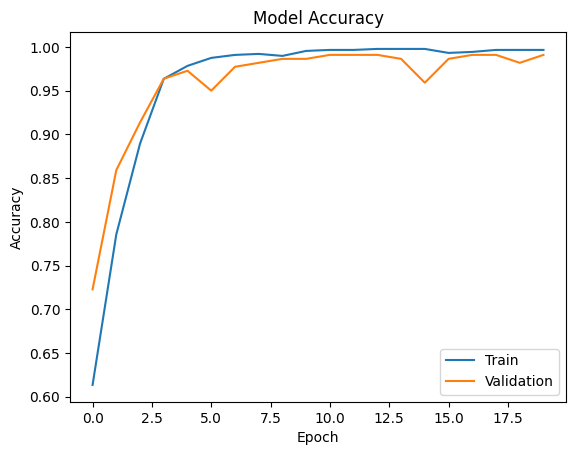

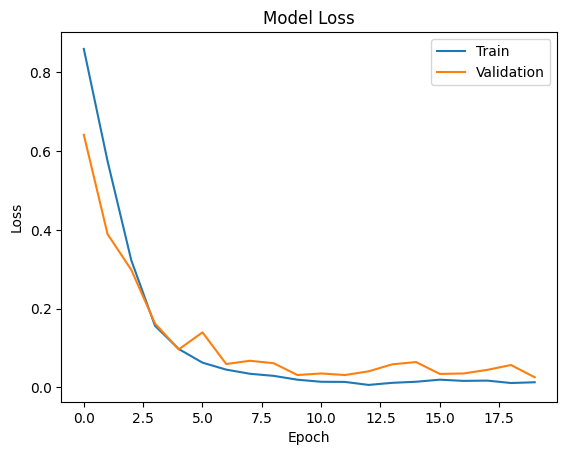

In [71]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()